# Conditional Dimensions tutorial

This tutorial is designed to demonstrate how users can implement various conditions in Devito using [ Conditional Dimension](https://github.com/devitocodes/devito/blob/e918e26757a4f0ea3c3c416b6e0f48f4e5023c37/devito/types/dimension.py#L635 "class ConditionalDimension(DerivedDimension):"). Devito can generate a great variety of loop kernels using its Domain Specific Language. We are going to show how we can generate loop structures in C language using Devito's DSL and how we can add conditional statements in them.

As always, we will begin by specifying some parameters. We will define a 2D iteration space and we will name the Dimensions as $i,j$.

## Part A

In Part A we introduce a simple example of a Devito Operator and gently introduce the use of Conditional Dimension.
First of all let's declare some initial parameters.

In [1]:
from devito import Dimension
%matplotlib inline

nx = 10
ny = 10
shape = (nx, ny) 
i = Dimension(name='i')
j = Dimension(name='j')

In the next cell we will define a 2D Function $f$ with shape $(nx,ny)$ and dimensions $i,j$. We will populate the 2D data of the Function with ones on its diagonal.

In [2]:
from devito import Function
import numpy as np

f = Function(name='f', shape=shape, dimensions=(i,j))
f.data[:,:] = np.eye(nx)
f.data[:,:] # Print data

Allocating memory for f(10, 10)


Data([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
      [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
      [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
      [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

Now lets construct a simple operator to increase the values of $ f $ by 1. We just need to update every element by 1 and execute the operator once. After the execution you can see every element updated by one.

In [3]:
from devito import Eq, Operator
op = Operator(Eq(f, f + 1))
op.apply()
f.data

Operator `Kernel` generated in 0.06 s
  * lowering.IET: 0.04 s (74.2 %)
     * specializing.IET: 0.03 s (55.7 %)
Flops reduction after symbolic optimization: [0 --> 0]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid1000/6f2211d9445e75fa20534d1a0f028f7edbb0c2e8.c` in 0.02 s from jit-cache
Operator `Kernel` run in 0.01 s
Performance[mode=advanced] arguments: {'nthreads': 6}


Data([[2., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      [1., 2., 1., 1., 1., 1., 1., 1., 1., 1.],
      [1., 1., 2., 1., 1., 1., 1., 1., 1., 1.],
      [1., 1., 1., 2., 1., 1., 1., 1., 1., 1.],
      [1., 1., 1., 1., 2., 1., 1., 1., 1., 1.],
      [1., 1., 1., 1., 1., 2., 1., 1., 1., 1.],
      [1., 1., 1., 1., 1., 1., 2., 1., 1., 1.],
      [1., 1., 1., 1., 1., 1., 1., 2., 1., 1.],
      [1., 1., 1., 1., 1., 1., 1., 1., 2., 1.],
      [1., 1., 1., 1., 1., 1., 1., 1., 1., 2.]], dtype=float32)

Every value has been updated by one. Now let's have a look at the generated code. We can see that we iterate over a 2D space, increasing every grid value by one.

In [4]:
print(op.ccode)

#define _POSIX_C_SOURCE 200809L
#include "stdlib.h"
#include "math.h"
#include "sys/time.h"
#include "xmmintrin.h"
#include "pmmintrin.h"
#include "omp.h"

struct dataobj
{
  void *restrict data;
  int * size;
  int * npsize;
  int * dsize;
  int * hsize;
  int * hofs;
  int * oofs;
} ;

struct profiler
{
  double section0;
} ;


int Kernel(struct dataobj *restrict f_vec, const int i_M, const int i_m, const int j_M, const int j_m, struct profiler * timers, const int nthreads)
{
  float (*restrict f)[f_vec->size[1]] __attribute__ ((aligned (64))) = (float (*)[f_vec->size[1]]) f_vec->data;
  /* Flush denormal numbers to zero in hardware */
  _MM_SET_DENORMALS_ZERO_MODE(_MM_DENORMALS_ZERO_ON);
  _MM_SET_FLUSH_ZERO_MODE(_MM_FLUSH_ZERO_ON);
  struct timeval start_section0, end_section0;
  gettimeofday(&start_section0, NULL);
  /* Begin section0 */
  #pragma omp parallel num_threads(nthreads)
  {
    #pragma omp for collapse(1) schedule(static,1)
    for (int i = i_m; i <= i_M; i += 1)
    {

It's time to  define a conditional that updates only the values of the array that are larger than 1, f(i,j)>1. The documentation of the conditional dimension is presented in [ Conditional Dimension](https://github.com/devitocodes/devito/blob/e918e26757a4f0ea3c3c416b6e0f48f4e5023c37/devito/types/dimension.py#L635 "class ConditionalDimension(DerivedDimension):") along with some nice examples. We name our Conditional Dimension 'ci'. When constructed we have to pass as an argument the parent dimension and the condition to satisfy. For this example we want to update again by one all the elements that are larger than 0, $f[i,j] > 0$ and smaller than 5, $f[i,j] < 5$. All the elements will be updated. We pass this dimension as implicit one to or operator. Have a sneak peek at the generated code and the data.


In [5]:
from devito import ConditionalDimension
from devito.symbolics import CondEq
from sympy import And

condition = And(f[i,j] > 0, f[i,j] < 5 , evaluate=False)
ci = ConditionalDimension(name='ci', parent=j, condition=condition)

op = Operator(Eq(f, f + 1, implicit_dims=ci))
op.apply()
print(op.ccode)
f.data


Operator `Kernel` generated in 0.05 s
  * lowering.IET: 0.04 s (84.1 %)
     * specializing.IET: 0.03 s (63.1 %)
        * optimize_halospots: 0.01 s (21.1 %)
        * make_parallel: 0.01 s (21.1 %)
        * place_casts: 0.01 s (21.1 %)
     * lower_dims: 0.01 s (21.1 %)
     * build: 0.01 s (21.1 %)
  * lowering.Expressions: 0.01 s (21.1 %)
  * lowering.Clusters: 0.01 s (21.1 %)
     * schedule: 0.01 s (21.1 %)
     * analyze: 0.01 s (21.1 %)
     * specializing.Clusters: 0.01 s (21.1 %)
        * blocking: 0.01 s (21.1 %)
        * fuse: 0.01 s (21.1 %)
        * lift: 0.01 s (21.1 %)
Flops reduction after symbolic optimization: [0 --> 0]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid1000/0201023b5339acc0c9f6c7a892077d0c2d762ecb.c` in 0.02 s from jit-cache
Operator `Kernel` run in 0.01 s
Performance[mode=advanced] arguments: {'nthreads': 6}


#define _POSIX_C_SOURCE 200809L
#include "stdlib.h"
#include "math.h"
#include "sys/time.h"
#include "xmmintrin.h"
#include "pmmintrin.h"
#include "omp.h"

struct dataobj
{
  void *restrict data;
  int * size;
  int * npsize;
  int * dsize;
  int * hsize;
  int * hofs;
  int * oofs;
} ;

struct profiler
{
  double section0;
} ;


int Kernel(struct dataobj *restrict f_vec, const int i_M, const int i_m, const int j_M, const int j_m, struct profiler * timers, const int nthreads)
{
  float (*restrict f)[f_vec->size[1]] __attribute__ ((aligned (64))) = (float (*)[f_vec->size[1]]) f_vec->data;
  /* Flush denormal numbers to zero in hardware */
  _MM_SET_DENORMALS_ZERO_MODE(_MM_DENORMALS_ZERO_ON);
  _MM_SET_FLUSH_ZERO_MODE(_MM_FLUSH_ZERO_ON);
  struct timeval start_section0, end_section0;
  gettimeofday(&start_section0, NULL);
  /* Begin section0 */
  #pragma omp parallel num_threads(nthreads)
  {
    #pragma omp for collapse(1) schedule(static,1)
    for (int i = i_m; i <= i_M; i += 1)
    {

Data([[3., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
      [2., 3., 2., 2., 2., 2., 2., 2., 2., 2.],
      [2., 2., 3., 2., 2., 2., 2., 2., 2., 2.],
      [2., 2., 2., 3., 2., 2., 2., 2., 2., 2.],
      [2., 2., 2., 2., 3., 2., 2., 2., 2., 2.],
      [2., 2., 2., 2., 2., 3., 2., 2., 2., 2.],
      [2., 2., 2., 2., 2., 2., 3., 2., 2., 2.],
      [2., 2., 2., 2., 2., 2., 2., 3., 2., 2.],
      [2., 2., 2., 2., 2., 2., 2., 2., 3., 2.],
      [2., 2., 2., 2., 2., 2., 2., 2., 2., 3.]], dtype=float32)

Our operator will be increasing by one as far as element value does not get larger than 5. You can execute the following cell a few times to notice this. All values will converge to 5.

In [6]:
# Execute this cell 4-5 times
op.apply()
f.data

Operator `Kernel` run in 0.01 s
Performance[mode=advanced] arguments: {'nthreads': 6}


Data([[4., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
      [3., 4., 3., 3., 3., 3., 3., 3., 3., 3.],
      [3., 3., 4., 3., 3., 3., 3., 3., 3., 3.],
      [3., 3., 3., 4., 3., 3., 3., 3., 3., 3.],
      [3., 3., 3., 3., 4., 3., 3., 3., 3., 3.],
      [3., 3., 3., 3., 3., 4., 3., 3., 3., 3.],
      [3., 3., 3., 3., 3., 3., 4., 3., 3., 3.],
      [3., 3., 3., 3., 3., 3., 3., 4., 3., 3.],
      [3., 3., 3., 3., 3., 3., 3., 3., 4., 3.],
      [3., 3., 3., 3., 3., 3., 3., 3., 3., 4.]], dtype=float32)

Now lets create 2 new 2D functions: Function $g$ and $h$. Let's initialize their data with 1's in their diagonal. There is no need to pass it to the operator. This time the $h$ will use the conditional dimension upon construction time. We add $i<5$ in the conditions and we update $h$ with $g + 1$ only for the first 5 rows. Have look at the generated data and the output data.

In [7]:
g = Function(name='g', shape=shape, dimensions=(i,j))
ci = ConditionalDimension(name='ci', parent=j, condition=And(g[i,j] > 0, g[i,j] < 5, i< 5 , evaluate=False))
h = Function(name='h', shape=shape, dimensions=(i,ci))
g.data[:,:] = np.eye(10)
h.data[:,:] = np.eye(10)

op = Operator(Eq(h, g + 1, implicit_dims=ci))
op.apply()
h.data
print(op.ccode)

Allocating memory for g(10, 10)
Allocating memory for h(10, 10)
Operator `Kernel` generated in 0.07 s
  * lowering.IET: 0.05 s (78.9 %)
     * specializing.IET: 0.04 s (63.1 %)
        * make_parallel: 0.02 s (31.6 %)
Flops reduction after symbolic optimization: [0 --> 0]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid1000/7fc1efb4e725b1eab7cad9e59cd19d3d8e1d8534.c` in 0.02 s from jit-cache
Operator `Kernel` run in 0.01 s
Performance[mode=advanced] arguments: {'nthreads_nonaffine': 6}


#define _POSIX_C_SOURCE 200809L
#include "stdlib.h"
#include "math.h"
#include "sys/time.h"
#include "xmmintrin.h"
#include "pmmintrin.h"
#include "omp.h"

struct dataobj
{
  void *restrict data;
  int * size;
  int * npsize;
  int * dsize;
  int * hsize;
  int * hofs;
  int * oofs;
} ;

struct profiler
{
  double section0;
} ;


int Kernel(struct dataobj *restrict g_vec, struct dataobj *restrict h_vec, const int i_M, const int i_m, const int j_M, const int j_m, struct profiler * timers, const int nthreads_nonaffine)
{
  float (*restrict g)[g_vec->size[1]] __attribute__ ((aligned (64))) = (float (*)[g_vec->size[1]]) g_vec->data;
  float (*restrict h)[h_vec->size[1]] __attribute__ ((aligned (64))) = (float (*)[h_vec->size[1]]) h_vec->data;
  /* Flush denormal numbers to zero in hardware */
  _MM_SET_DENORMALS_ZERO_MODE(_MM_DENORMALS_ZERO_ON);
  _MM_SET_FLUSH_ZERO_MODE(_MM_FLUSH_ZERO_ON);
  struct timeval start_section0, end_section0;
  gettimeofday(&start_section0, NULL);
  /* Begin sec

You can see that now `h` was been updated only for the first 5 rows.

## PART B - Game of Life WORK IN PROGRESS

Live cells:

- a cell with a live neighbour on its i-1 and j+1 neighbour will get live (1).


Allocating memory for gl(10, 10)
Operator `Kernel` generated in 0.05 s
  * lowering.IET: 0.04 s (92.1 %)
     * specializing.IET: 0.03 s (69.1 %)
        * optimize_halospots: 0.01 s (23.1 %)
        * make_parallel: 0.01 s (23.1 %)
        * make_simd: 0.01 s (23.1 %)
     * lower_dims: 0.01 s (23.1 %)
     * build: 0.01 s (23.1 %)
  * lowering.Expressions: 0.01 s (23.1 %)
  * lowering.Clusters: 0.01 s (23.1 %)
     * specializing.Clusters: 0.01 s (23.1 %)
        * blocking: 0.01 s (23.1 %)
        * fuse: 0.01 s (23.1 %)
        * optimize_pows: 0.01 s (23.1 %)
     * analyze: 0.01 s (23.1 %)
     * schedule: 0.01 s (23.1 %)
Flops reduction after symbolic optimization: [0 --> 0]


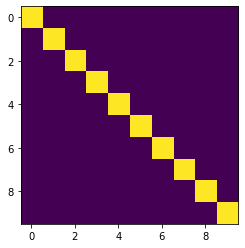

In [8]:
import matplotlib.pyplot as plt

gl = Function(name='gl', shape=shape, dimensions=(i,j))
gl.data[:,:] = np.eye(nx)
plt.imshow(gl.data) # Show data

# TO FIX as subdomain? 
# Adding i>0 j<9 to avoid OOB accesses
condition = And(gl[i-1,j] > 0, gl[i,j+1] > 0, i > 0, j<9, evaluate=False)

ci = ConditionalDimension(name='ci2', parent=j, condition=condition)

Eq1 = Eq(gl, 1, implicit_dims=(ci))

op = Operator([Eq1])




Operator `Kernel` fetched `/tmp/devito-jitcache-uid1000/1856a355eb857e73713a587e9074cfbe04f3da29.c` in 0.01 s from jit-cache
Operator `Kernel` run in 0.01 s
Performance[mode=advanced] arguments: {'nthreads': 6}


#define _POSIX_C_SOURCE 200809L
#include "stdlib.h"
#include "math.h"
#include "sys/time.h"
#include "xmmintrin.h"
#include "pmmintrin.h"
#include "omp.h"

struct dataobj
{
  void *restrict data;
  int * size;
  int * npsize;
  int * dsize;
  int * hsize;
  int * hofs;
  int * oofs;
} ;

struct profiler
{
  double section0;
} ;


int Kernel(struct dataobj *restrict gl_vec, const int i_M, const int i_m, const int j_M, const int j_m, struct profiler * timers, const int nthreads)
{
  float (*restrict gl)[gl_vec->size[1]] __attribute__ ((aligned (64))) = (float (*)[gl_vec->size[1]]) gl_vec->data;
  /* Flush denormal numbers to zero in hardware */
  _MM_SET_DENORMALS_ZERO_MODE(_MM_DENORMALS_ZERO_ON);
  _MM_SET_FLUSH_ZERO_MODE(_MM_FLUSH_ZERO_ON);
  struct timeval start_section0, end_section0;
  gettimeofday(&start_section0, NULL);
  /* Begin section0 */
  #pragma omp parallel num_threads(nthreads)
  {
    #pragma omp for collapse(1) schedule(static,1)
    for (int i = i_m; i <= i_M; i += 1)


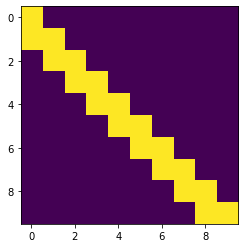

In [9]:
print(op.ccode)
op.apply()
plt.imshow(gl.data)

Operator `Kernel` run in 0.01 s
Performance[mode=advanced] arguments: {'nthreads': 6}


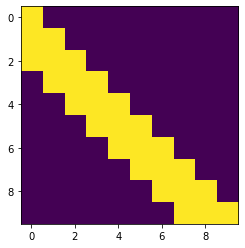

In [10]:
# Execute this cell a few times to see more cells getting live

op.apply()
plt.imshow(gl.data)